In [1]:
!pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
import time
import random
import os # Импортируем библиотеку os для раоты с файловой системой
from PIL import Image # импортируем модель Image для работы с изображениями
#import seaborn as sns
#sns.set_style('darkgrid')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height =  320 # Высота уменьшенной картинки 
directory = '/content/drive/My Drive/My Drive/Базы/Поражения/' # Указываем путь к обучающей выборке с оригинальными изображениями
num_classes = 2 # Количество классов на изображении

In [4]:
benign = [] # Создаем пустой список для хранений оригинльных изображений обучающей выборки

s=0
cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + 'benign')): # Проходим по всем файлам в каталоге по указанному пути     
    s+=1
    #print(s)
    benign.append(image.load_img(os.path.join(directory + 'benign',filename),
                                       target_size=(img_width, img_height))) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      
print ('Обучающая выборка загржуена. Время загрузки: ', time.time() - cur_time, 'c', sep='') # Отображаем время загрузки картинок обучающей выборки

Обучающая выборка загржуена. Время загрузки: 24.49386739730835c


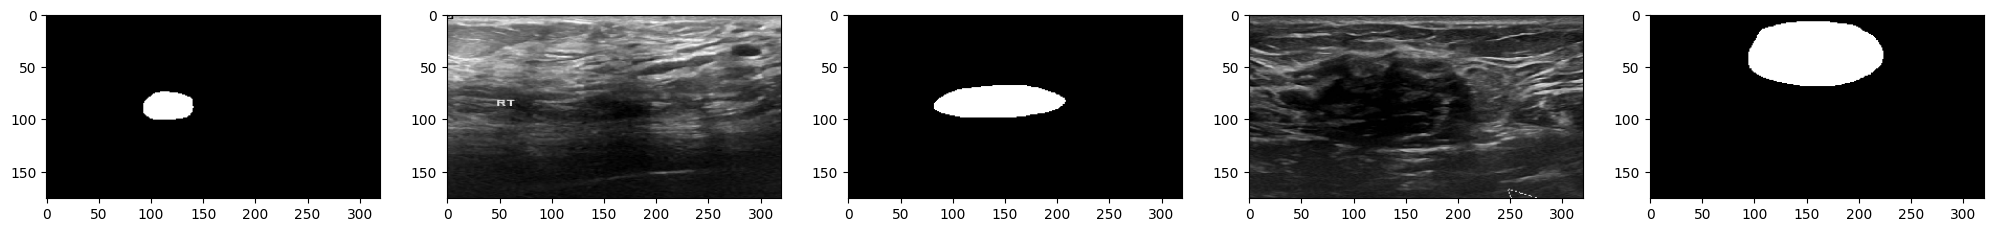

In [5]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = random.choice(benign) # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [6]:
images_origin = benign[::2]
images_segment = benign[1::2]

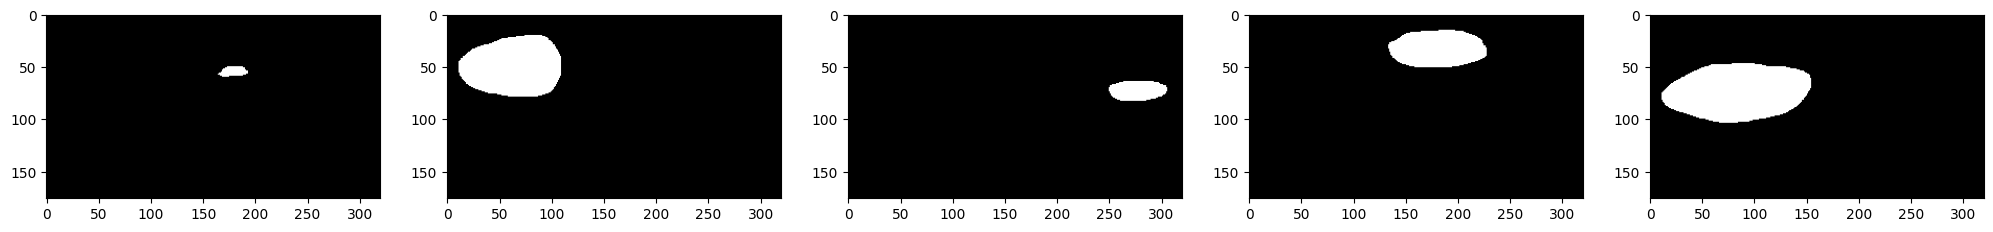

In [7]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = images_segment[i] # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [8]:
len(images_segment)

421

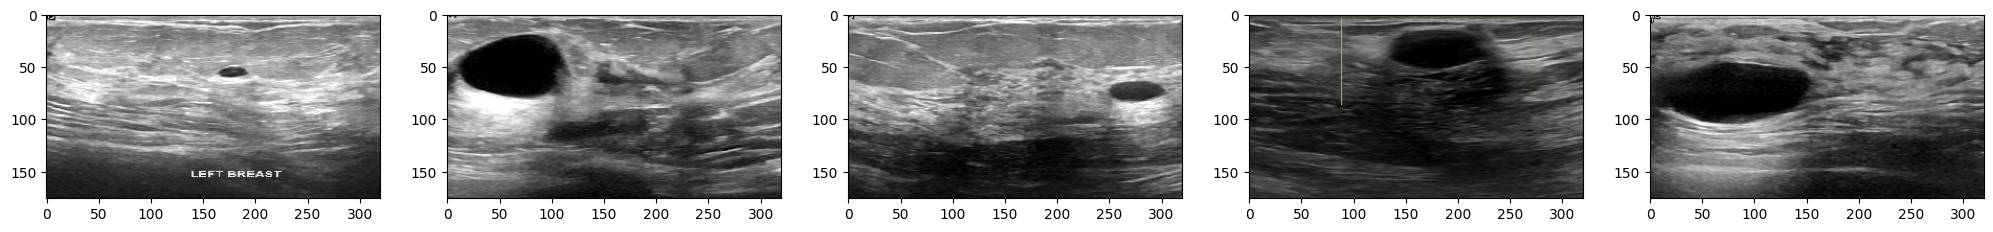

In [9]:
n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 5)) #Создаем полотно из n графиков
for i in range(n): # Выводим в цикле n случайных изображений
  img = images_origin[i] # Выбираем случайное фото для отображения
  axs[i].imshow(img) # Отображаем фото
plt.show() #Показываем изображения

In [10]:
len(images_origin)

421

In [11]:
# Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
    index=0
    if (color[0] + color[1] + color[2]) > 20  : index = 1 # самолет    
    return index 

In [12]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходному размеру
  return yt # Возвращаем сформированный массив

In [13]:
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегментации
  for seg in data: # Пробегаем по всем файлам набора с сегментированными изображениями
    y = image.img_to_array(seg) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

In [14]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_origin: 
    x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(x) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(421, 176, 320, 3)


In [15]:
cur_time = time.time()
yTrain = yt_prep(images_segment, num_classes) 
print('Время обработки: ', round(time.time() - cur_time, 2),'c')

100
200
300
400
Время обработки:  313.88 c


In [16]:
x_train, x_val, y_train, y_val = train_test_split(xTrain, yTrain, test_size = 0.1)

In [17]:
y_train.shape

(378, 176, 320, 2)

In [18]:
y_val.shape

(43, 176, 320, 2)

In [19]:
# One hot encoding для 2 классов

def oneHot(dSet):                  # dSet в нашем случае разметка
  dSet2 = []
  for t in range(dSet.shape[0]):
    yy = dSet[t].copy()
    yyNew = []

    for i in range(yy.shape[0]):
      currYYstr = 0
      for j in range(yy.shape[1]):   # Цвет каждого пикселя 
        if yy[i][j] == 0:            # Если не самолет (его значение больше нуля), то
          currYYstr = 0              # Присваиваем 0
        else:                        # Если это самолет, то
          currYYstr = 1              # Присваиваем 1
        yyNew.append(currYYstr)      # Заносим в новый список, где есть только 1 канал

    yyNew = np.array(yyNew)          # Список закодированных пикселей
    dSet2.append(yyNew)              # Список закодированных картинок
  dSet2 = np.array(dSet2)

  dSet2 = np.reshape(dSet2,(dSet.shape[0],dSet.shape[1],dSet.shape[2],1))
  
  return dSet2

In [20]:
outYTrain = oneHot(y_train[:,:,:,0]) # переводим в one hot encoding

In [21]:
outYVal = oneHot(y_val[:,:,:,0]) # переводим в one hot encoding

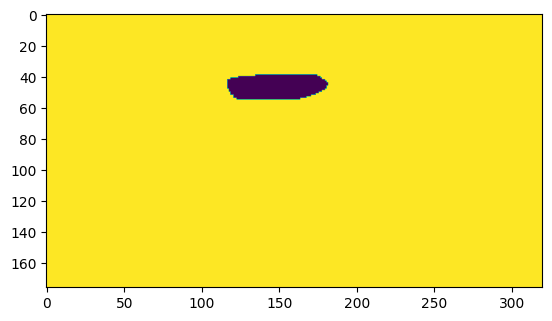

In [22]:
plt.imshow(outYTrain[0][:,:,-1])

In [23]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

In [24]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPNet(conv_size = 32, num_classes = 2, input_shape = (272, 480, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(conv_size, (3, 3), padding='same')(img_input)
    x = BatchNormalization()(x)
    x_c_1 = Activation('relu')(x)
    x = Conv2D(conv_size, (3, 3), padding='same')(x_c_1)
    x = BatchNormalization()(x)
    x_c_2 = Activation('relu')(x)
    x = x_c_2

    x_mp_2 = MaxPooling2D(2)(x)
    x_mp_4 = MaxPooling2D(4)(x)
    x_mp_8 = MaxPooling2D(8)(x)
    #x_mp_16 = MaxPooling2D(16)(x)
    #x_mp_32 = MaxPooling2D(32)(x)

    x_mp_2 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_2)
    x_mp_4 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_4)
    x_mp_8 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_8)
    #x_mp_16 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_16)
    #x_mp_32 = Conv2D(conv_size, (3, 3), padding='same', activation='relu')(x_mp_32)

    x_mp_2 = Conv2DTranspose(conv_size, (2, 2), strides=(2, 2), activation='relu')(x_mp_2)
    x_mp_4 = Conv2DTranspose(conv_size, (4, 4), strides=(4, 4), activation='relu')(x_mp_4)
    x_mp_8 = Conv2DTranspose(conv_size, (8, 8), strides=(8, 8), activation='relu')(x_mp_8)
    #x_mp_16 = Conv2DTranspose(conv_size, (16, 16), strides=(16, 16), activation='relu')(x_mp_16)
    #x_mp_32 = Conv2DTranspose(conv_size, (32, 32), strides=(32, 32), activation='relu')(x_mp_32)

    #fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])
    fin = concatenate([img_input, x_c_1, x_c_2, x_mp_2, x_mp_4, x_mp_8])
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv2D(conv_size, (3, 3), padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv2D(num_classes-1, (3, 3), activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    return model

In [25]:
modelPSP = PSPNet(64, 2, (img_width, img_height,3))

In [26]:
history = modelPSP.fit(x_train, outYTrain, epochs=35, batch_size=16, validation_data = (x_val, outYVal)) # Обучаем модель на выборке по трем классам

Epoch 1/35
24/24 [==============================] - 46s 963ms/step - loss: 0.3373 - dice_coef: 0.8534 - val_loss: 0.3622 - val_dice_coef: 0.8651
Epoch 2/35
24/24 [==============================] - 11s 467ms/step - loss: 0.2585 - dice_coef: 0.9033 - val_loss: 0.3761 - val_dice_coef: 0.8385
Epoch 3/35
24/24 [==============================] - 11s 470ms/step - loss: 0.2297 - dice_coef: 0.9222 - val_loss: 0.4009 - val_dice_coef: 0.8110
Epoch 4/35
24/24 [==============================] - 11s 470ms/step - loss: 0.2171 - dice_coef: 0.9302 - val_loss: 0.4148 - val_dice_coef: 0.8015
Epoch 5/35
24/24 [==============================] - 11s 480ms/step - loss: 0.2096 - dice_coef: 0.9346 - val_loss: 0.3846 - val_dice_coef: 0.8181
Epoch 6/35
24/24 [==============================] - 11s 472ms/step - loss: 0.2024 - dice_coef: 0.9383 - val_loss: 0.3353 - val_dice_coef: 0.8467
Epoch 7/35
24/24 [==============================] - 12s 483ms/step - loss: 0.1964 - dice_coef: 0.9413 - val_loss: 0.2714 - val_dic

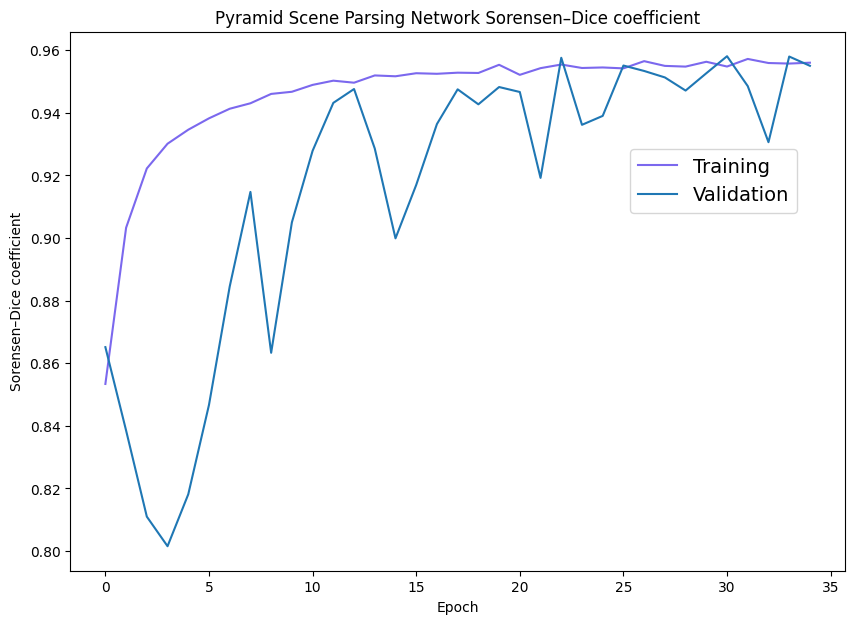

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['dice_coef'], label = 'Training',color = 'mediumslateblue')
plt.plot(history.history['val_dice_coef'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Sorensen–Dice coefficient')
plt.legend(bbox_to_anchor=(0.95,0.8), fontsize=14)
plt.title('Pyramid Scene Parsing Network Sorensen–Dice coefficient')
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()


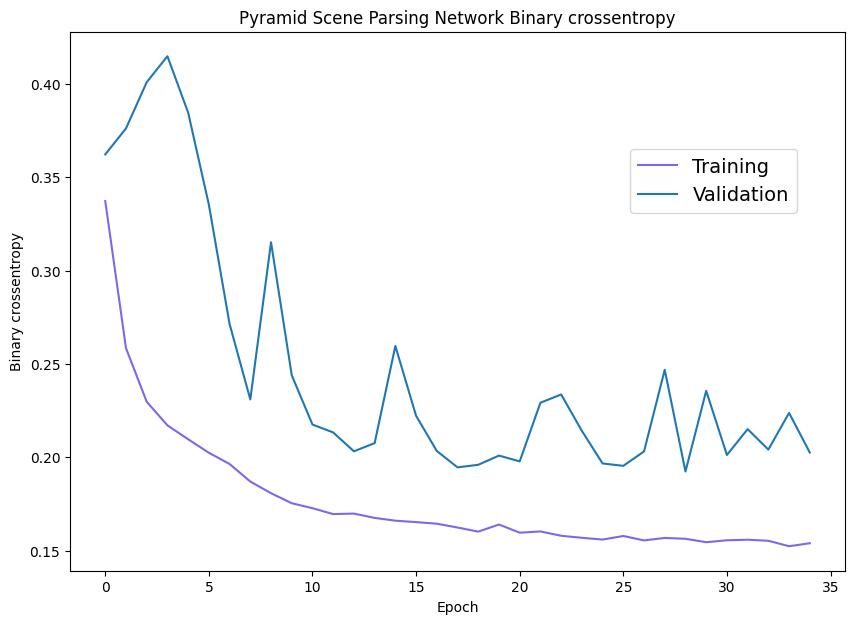

In [30]:
plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label = 'Training', color = 'mediumslateblue')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Binary crossentropy')
#plt.yscale('log')
plt.legend(bbox_to_anchor=(0.95,0.8), fontsize=14)
plt.title('Pyramid Scene Parsing Network Binary crossentropy')
#plt.grid(color='grey', linestyle='-', linewidth=0.5)
plt.show()

1/1 [==============================] - 0s 31ms/step


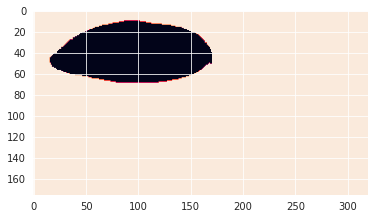

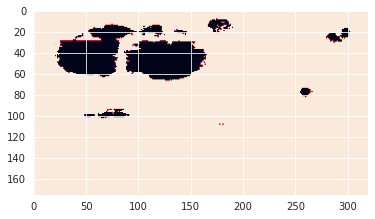

In [ ]:
pred = modelPSP.predict(x_val[:10]) # Предсказываем тестовые картинки

# Сравним сгенерированную картинку сегментации с обучающей
n = 2
plt.imshow(outYVal[n][:,:,-1])
plt.show()
img = 255*np.uint8(np.round(pred[n]))[:,:,-1]
plt.imshow(img)
plt.show()
